In [1]:
!python -V

Python 3.9.16


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
# Add mlflow
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='/Users/addingtongraham/github-repos/mlops/experiment-tracking/mlruns/1', creation_time=1683754500621, experiment_id='1', last_update_time=1683754500621, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829626

/var/folders/04/whwls5095tz8s5mxv15jpsvr0000gn/T/ipykernel_73507/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/04/whwls5095tz8s5mxv15jpsvr0000gn/T/ipykernel_73507/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

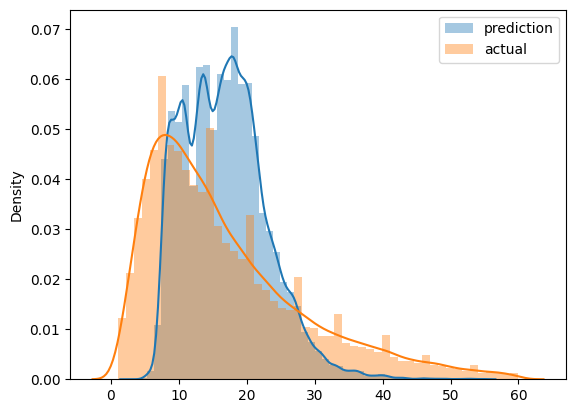

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206931833

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

## DEFINE MLFLOW RUN

In [19]:
with mlflow.start_run():
    
    mlflow.set_tag('developer', 'kai')
    mlflow.log_param('train-data-path', './data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', './data/green_tripdata_2021-02.parquet')
    
    alpha = 0.012
    mlflow.log_param('alpha', alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    mse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('mse', mse)

## Hyper Parameter Tuning 

In [20]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [23]:
# define train and validation
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,    
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[11:59:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.54741                          
[1]	validation-rmse:14.73920                          
[2]	validation-rmse:12.60128                          
[3]	validation-rmse:10.99616                          
[4]	validation-rmse:9.80589                           
[5]	validation-rmse:8.93577                           
[6]	validation-rmse:8.30833                           
[7]	validation-rmse:7.86108                           
[8]	validation-rmse:7.54025                           
[9]	validation-rmse:7.30966                           
[10]	validation-rmse:7.14714                          
[11]	validation-rmse:7.02713                          
[12]	validation-rmse:6.93861                          
[13]	validation-rmse:6.87466                          
[14]	validation-

KeyboardInterrupt: 